# Réseau de neurone à récurrence (RNN)


Exemple de RNN sur données générées de type séries temporelles, avec pytorch
 

[REQUIREMENTS.txt](#requirements)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Générer des données sans bruit
N = 1000
series = np.sin(0.1*np.arange(N))

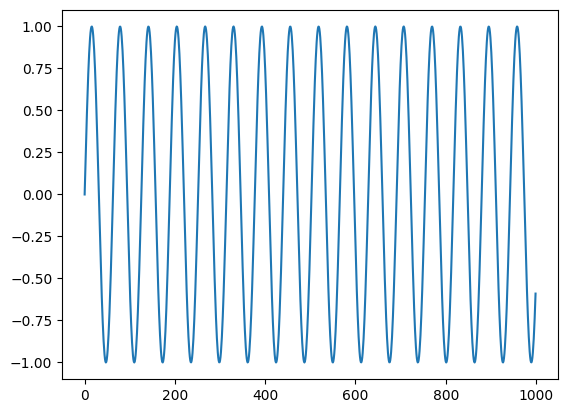

In [3]:
plt.plot(series)
plt.show()

In [4]:
# --- Créer le jeu de données

T = 10
X = []
y = []

for t in range(len(series) - T):
    _x = series[t:t+T]
    X.append(_x)
    
    _y = series[t+T]
    y.append(_y)

X = np.array(X).reshape(-1, T, 1)
y = np.array(y).reshape(-1, 1)
N = len(X)
print('X.shape', X.shape, 'y.shape', y.shape)

X.shape (990, 10, 1) y.shape (990, 1)


In [5]:
class SimpleRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.RNN(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            nonlinearity = 'relu',
            batch_first = True
        )
        
        self.dense = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

        out, _ = self.rnn(X, h0)
        out = self.dense(out[:, -1, :])

        return out

In [6]:
model = SimpleRNN(n_inputs=1, n_hidden=5, n_rnnlayers=1, n_outputs=1)

In [7]:
# --- GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda:0


SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (dense): Linear(in_features=5, out_features=1, bias=True)
)

In [8]:
# --- Entraîner le modèle
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

In [9]:
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(y[:-N//2].astype(np.float32))

X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(y[-N//2:].astype(np.float32))

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [10]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=200):
    train_losses = test_losses = np.zeros(epochs)

    for it in range(epochs):
        optimizer.zero_grad()

        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        loss.backward()
        optimizer.step()

        outputs_test = model(X_test)
        loss_test = criterion(outputs_test, y_test)

        train_losses[it] = loss.item()
        test_losses[it] = loss_test.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it+1}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {loss_test.item():.4f}')
        
    return train_losses, test_losses

In [11]:
# lancer la boucle d'entraînement

train_losses, test_losses = full_gd(
    model = model,
    criterion = criterion,
    optimizer = optimizer,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test
)

Epoch 5/200, Train Loss: 0.4932, Test Loss: 0.4971
Epoch 10/200, Train Loss: 0.4499, Test Loss: 0.4174
Epoch 15/200, Train Loss: 0.2560, Test Loss: 0.2084
Epoch 20/200, Train Loss: 0.0655, Test Loss: 0.0519
Epoch 25/200, Train Loss: 0.0680, Test Loss: 0.0670
Epoch 30/200, Train Loss: 0.0334, Test Loss: 0.0196
Epoch 35/200, Train Loss: 0.0082, Test Loss: 0.0144
Epoch 40/200, Train Loss: 0.0172, Test Loss: 0.0129
Epoch 45/200, Train Loss: 0.0027, Test Loss: 0.0042
Epoch 50/200, Train Loss: 0.0077, Test Loss: 0.0063
Epoch 55/200, Train Loss: 0.0019, Test Loss: 0.0022
Epoch 60/200, Train Loss: 0.0035, Test Loss: 0.0031
Epoch 65/200, Train Loss: 0.0012, Test Loss: 0.0012
Epoch 70/200, Train Loss: 0.0014, Test Loss: 0.0011
Epoch 75/200, Train Loss: 0.0003, Test Loss: 0.0003
Epoch 80/200, Train Loss: 0.0003, Test Loss: 0.0002
Epoch 85/200, Train Loss: 0.0001, Test Loss: 0.0002
Epoch 90/200, Train Loss: 0.0002, Test Loss: 0.0001
Epoch 95/200, Train Loss: 0.0001, Test Loss: 0.0001
Epoch 100/200

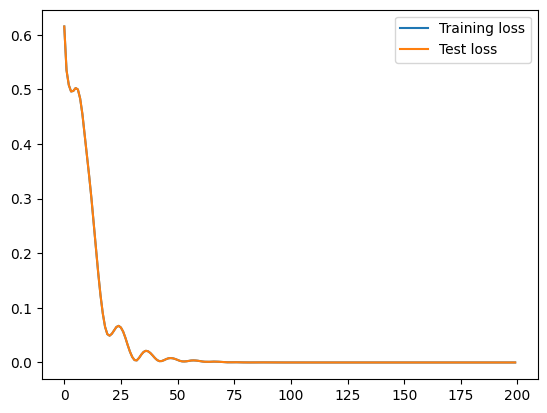

In [12]:
# Loss par itération
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

In [13]:
# --- Prédictions avec le modèle

validation_target = y[-N//2:]
validation_predictions = []

# dernier input des données d'entraînement
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    _input = last_x.reshape(1, T, 1)
    pred = model(_input)

    validation_predictions.append(pred[0,0].item())

    # créer le nouvel input
    last_x = torch.cat((last_x[1:], pred[0]))


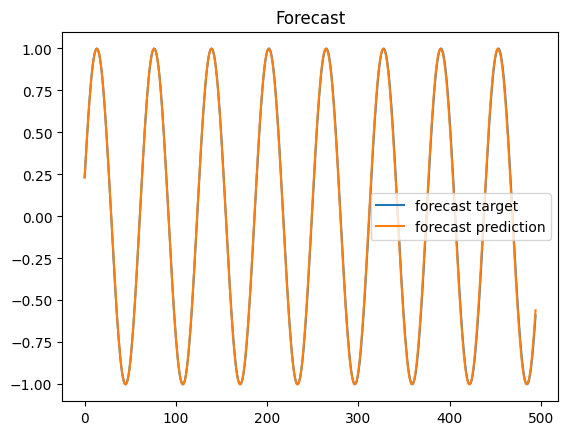

In [15]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.title('Forecast')
plt.legend()
plt.show()

## <a id="requirements" style="color:black">REQUIREMENTS.txt</a>

<span style="color:orange">Ce notebook a été créé avec python 3.10</span>

Requirements.txt  

```
alembic==1.13.2
aniso8601==9.0.1
anyio==4.4.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
async-lru==2.0.4
attrs==23.2.0
Babel==2.15.0
bcrypt==4.1.3
beautifulsoup4==4.12.3      
bleach==6.1.0
blinker==1.8.2
boto3==1.35.35
botocore==1.35.40
cachetools==5.4.0
certifi==2024.6.2
cffi==1.16.0
charset-normalizer==3.3.2   
click==8.1.7
cloudpickle==3.0.0
colorama==0.4.6
comm==0.2.2
contourpy==1.2.1
cryptography==42.0.8        
cycler==0.12.1
databricks-sdk==0.31.1      
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
Deprecated==1.2.14
docker==7.1.0
entrypoints==0.4
exceptiongroup==1.2.1
executing==2.0.1
fastjsonschema==2.19.1
filelock==3.13.1
Flask==3.0.3
fonttools==4.53.0
fqdn==1.5.1
fsspec==2024.2.0
gitdb==4.0.11
GitPython==3.1.43
google-auth==2.34.0
graphene==3.3
graphql-core==3.2.3
graphql-relay==3.2.0
greenlet==3.0.3
h11==0.14.0
httpcore==1.0.5
httpx==0.27.0
idna==3.7
imageio==2.35.1
importlib_metadata==7.1.0
intel-openmp==2021.4.0
ipykernel==6.29.4
ipython==8.25.0
ipywidgets==8.1.3
isoduration==20.11.0
itsdangerous==2.2.0
jedi==0.19.1
Jinja2==3.1.3
jmespath==1.0.1
joblib==1.4.2
json5==0.9.25
jsonpointer==3.0.0
jsonschema==4.22.0
jsonschema-specifications==2023.12.1
jupyter==1.0.0
jupyter-console==6.6.3
jupyter-events==0.10.0
jupyter-lsp==2.2.5
jupyter_client==8.6.2
jupyter_core==5.7.2
jupyter_server==2.14.1
jupyter_server_terminals==0.5.3
jupyterlab==4.2.2
jupyterlab_pygments==0.3.0
jupyterlab_server==2.27.2
jupyterlab_widgets==3.0.11
kiwisolver==1.4.5
lazy_loader==0.4
Mako==1.3.5
Markdown==3.6
MarkupSafe==2.1.5
matplotlib==3.9.0
matplotlib-inline==0.1.7
mistune==3.0.2
mkl==2021.4.0
mlflow==2.15.1
mlflow-skinny==2.15.1
mpmath==1.3.0
nbclient==0.10.0
nbconvert==7.16.4
nbformat==5.10.4
nest-asyncio==1.6.0
networkx==3.2.1
notebook==7.2.1
notebook_shim==0.2.4
numpy==1.26.3
opentelemetry-api==1.25.0
opentelemetry-sdk==1.25.0
opentelemetry-semantic-conventions==0.46b0
overrides==7.7.0
packaging==24.1
pandas==2.2.2
pandocfilters==1.5.1
paramiko==3.4.0
parso==0.8.4
pillow==10.2.0
platformdirs==4.2.2
prometheus_client==0.20.0
prompt_toolkit==3.0.47
protobuf==5.28.2
psutil==5.9.8
pure-eval==0.2.2
pyarrow==15.0.2
pyasn1==0.6.0
pyasn1_modules==0.4.0
pycparser==2.22
Pygments==2.18.0
PyNaCl==1.5.0
pyparsing==3.1.2
pysftp==0.2.8
python-dateutil==2.9.0.post0
python-json-logger==2.0.7
pytz==2024.1
pywin32==306
pywinpty==2.0.13
PyYAML==6.0.1
pyzmq==26.0.3
qtconsole==5.5.2
QtPy==2.4.1
querystring-parser==1.2.4
referencing==0.35.1
requests==2.32.3
rfc3339-validator==0.1.4
rfc3986-validator==0.1.1
rpds-py==0.18.1
rsa==4.9
s3transfer==0.10.3
scikit-image==0.24.0
scikit-learn==1.5.1
scipy==1.14.0
Send2Trash==1.8.3
six==1.16.0
smmap==5.0.1
sniffio==1.3.1
soupsieve==2.5
SQLAlchemy==2.0.31
sqlparse==0.5.1
stack-data==0.6.3
sympy==1.12
tbb==2021.11.0
terminado==0.18.1
threadpoolctl==3.5.0
tifffile==2024.9.20
tinycss2==1.3.0
tomli==2.0.1
torch==2.3.1+cu121
torchaudio==2.3.1+cu121
torchvision==0.18.1+cu121
tornado==6.4.1
traitlets==5.14.3
types-python-dateutil==2.9.0.20240316
typing_extensions==4.9.0
tzdata==2024.1
uri-template==1.3.0
urllib3==2.2.1
waitress==3.0.0
wcwidth==0.2.13
webcolors==24.6.0
webencodings==0.5.1
websocket-client==1.8.0
Werkzeug==3.0.3
widgetsnbextension==4.0.11
wrapt==1.16.0
zipp==3.19.2
```